Source of inspiration for this notebook was tutorial, https://explained.ai/gradient-boosting/index.html, written by Terence Par and Jeremy Howard. <br>
I'm writting this notebook to reproduce tutorial's explanations using Scikit-learn GBM (Gradient Boosting Model). <br>

Writting this notebook has more advantages, at least for me :
- the best way for me to learn/understand a technical article is by coding/trying to implement it.
- it will help me in the future to remember faster and easier all the informations, without reading again the whole tutorial.


# Imports

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree as sklearn_tree

from dtreeviz import trees as dtree
import matplotlib.pyplot as plt
import graphviz

import pandas as pd
import numpy as np

# GBM regression : distance to target

GBM is a <span class="mark">composite model</span> which combines the efforts of multiple <span class="mark">weak models</span> to build a much stronger model. <br> Most of the libraries will use <span class="mark">decision trees</span> as weak models.
Each additional weak model will be trained on the mistakes from the previews weak model. In case of regression, we consider the mistakes the residual values. Residual value is the difference, (y - y'), between target variable, y, and composite model's predictions, y'.

## Create dataset
I've created the same dataset as in the tutorial, to compare the results based on the same input. <br>
The dataset contains two columns and only five rows. 
- sqfeet means the square feet area of an apartment
- rent means the price to rent the apartment

In [22]:
dataset = pd.DataFrame({"sqfeet": [750, 800, 850, 900, 950], "rent":[1160,1200, 1280, 1450, 2000]})

In [79]:
dataset

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


## Create features and GBM model
I've chosen the same features, target variable. <br>
To compare the results, I've trained a GradientBoostringRegressor model from scikit-learn library. The hyperparameter values are the same as in the tutorial.


In [80]:
features = ["sqfeet"]
y = "rent"
rent_gbm = GradientBoostingRegressor(max_depth=1, n_estimators=3, criterion="mse", learning_rate=1)
rent_gbm.fit(dataset[features], dataset[y])

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Investigate the model 
By model investigation, I want to get two things :
    - to have the same results as in the tutorial
    - to simulate the building process of boosting model and to compare the results with the original model (gbm) 

In [81]:
def apply_init_model(dataset_gbm):
    """
    The first weak model is the mean(average) model. It will simply predict the mean of true target values.
    Let's name it F0 model and add its predictions to a new column F0.
    """
    dataset_gbm["F0"] = dataset_gbm[y].mean()
    
    # create residual values between target variable and predictions from current composite model, F0. 
    dataset_gbm[f"{y} - F0"] = dataset_gbm[y] - dataset_gbm[f"F0"]

    
def apply_weak_model(weak_model, index, dataset_gbm):
     
    # calculate the predictions for current weak model 
    dataset_gbm[f"weak_pred_{index}"] = weak_model.predict(dataset_gbm[features])
    
    # calculate the predictions for new composite model, using the predictions from previous composite model + predictions from current weak model
    dataset_gbm[f"F{index}"] = dataset_gbm[f"F{index - 1}"] + dataset_gbm[f"weak_pred_{index}"]
    
    # calculate the residual values between target variables and current composite model's predictions, (y - F_index)
    dataset_gbm[f"{y} - F{index}"] = dataset_gbm[y] - dataset_gbm[f"F{index}"]

    # get index node samples for each tree node. This will help for tree sample investigation
    node_samples = dtree.ShadowDecTree.node_samples(weak_model, dataset_gbm[features])
    
    # visualize decision tree 
    decision_tree_viz = dtree.dtreeviz(weak_model, X_train=dataset_gbm[features], y_train=dataset_gbm[f"{y} - F{index - 1}"], feature_names=features, target_name=f"{y} - F{index - 1}", fancy=True, scale=3.0)

    return dataset_gbm, node_samples, decision_tree_viz
    

In [82]:
# Create a copy of dataset, because we will update the state of dataset in the following steps
dataset_gbm = dataset.copy()
dataset_gbm

,sqfeet,rent
0,750,1160
1,800,1200
2,850,1280
3,900,1450
4,950,2000


Additional column meaning : 
- 'F0' column contains predictions of initial model, mean model. It simply calculate the mean of target variable. The mean value is chosen because it's the single value which minimize the MSE.
- 'rent - F0' is the residual value between target variable, rent, and F0 predictions. This column will become the target variable for the next weak model. 

In [83]:
apply_init_model(dataset_gbm)
dataset_gbm

,sqfeet,rent,F0,rent - F0
0,750,1160,1418.0,-258.0
1,800,1200,1418.0,-218.0
2,850,1280,1418.0,-138.0
3,900,1450,1418.0,32.0
4,950,2000,1418.0,582.0


Bellow, we will use the trained weak models from our rent_gbm model, but the building process of a composite model will be implemented in apply_weak_model function. <br>
The goal is to investigate the results after each step, to visualize the weak models and in the end to ckeck if we will obtain the same results as original rent_gbm model.

### Investigate the first weak model

In [84]:
weak_model_1 = rent_gbm.estimators_[0][0]
dataset_gbm, node_samples_1, decision_tree_viz_1 = apply_weak_model(weak_model_1, 1, dataset_gbm)

Additional column meaning : 
- 'weak_pred_1' contains predictions of first weak model. I just want to recap that this first weak model was <span class="mark">trained on features "sqfeet" and target variable "rent - F0"</span>
- 'F1' contains predictions of updated composite model (F0 + weak_pred_1).
- 'rent - F1' is the residual value between target variable, rent, and F1 predictions. This column will become the target variable for the next weak model. 

In [85]:
dataset_gbm

,sqfeet,rent,F0,rent - F0,weak_pred_1,F1,rent - F1
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5
4,950,2000,1418.0,582.0,582.0,2000.0,0.0


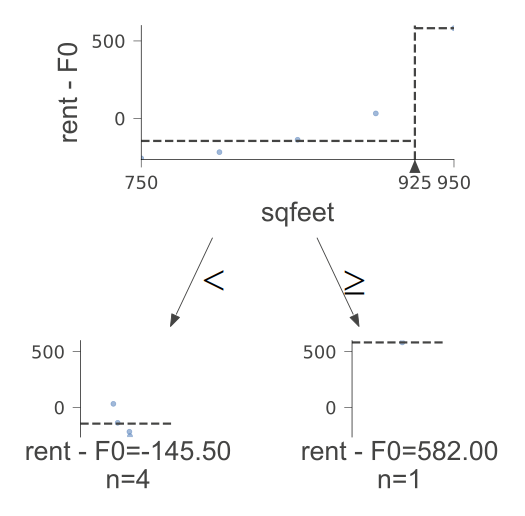

In [86]:
decision_tree_viz_1

In [87]:
print("Samples from node 1")
print(dataset_gbm.iloc[node_samples_1[1]][features + ["rent - F0"]])
print(f"Prediction for node 1 : {dataset_gbm.iloc[node_samples_1[1]]['rent - F0'].mean()}")

Samples from node 1
   sqfeet  rent - F0
0     750     -258.0
1     800     -218.0
2     850     -138.0
3     900       32.0
Prediction for node 1 : -145.5


In [88]:
print("Samples from node 2")
print(dataset_gbm.iloc[node_samples_1[2]][features + ["rent - F0"]])
print(f"Prediction for node 2 : {dataset_gbm.iloc[node_samples_1[2]]['rent - F0'].mean()}")

Samples from node 2
   sqfeet  rent - F0
4     950      582.0
Prediction for node 2 : 582.0


### Investigate the second weak model

In [89]:
weak_model_2 = rent_gbm.estimators_[1][0]
dataset_gbm, node_samples_2, decision_tree_viz_2 = apply_weak_model(weak_model_2, 2, dataset_gbm)

In [90]:
dataset_gbm

,sqfeet,rent,F0,rent - F0,weak_pred_1,F1,rent - F1,weak_pred_2,F2,rent - F2
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667


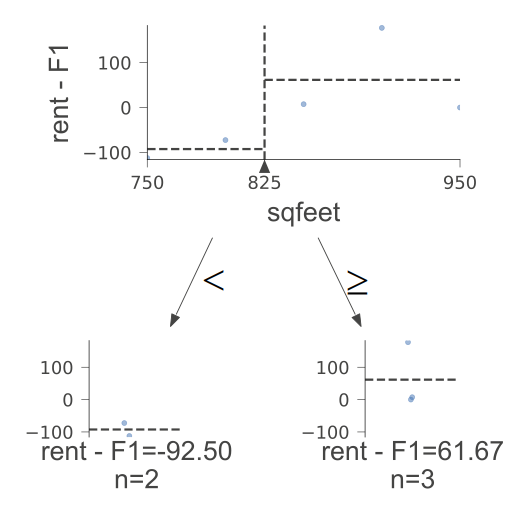

In [91]:
decision_tree_viz_2

In [98]:
print("Samples from node 1")
print(dataset_gbm.iloc[node_samples_2[1]][features + ["rent - F1"]])
print(f"Prediction for node 1 : {dataset_gbm.iloc[node_samples_2[1]]['rent - F1'].mean()}")

Samples from node 1
   sqfeet  rent - F1
0     750     -112.5
1     800      -72.5
Prediction for node 1 : -92.5


In [99]:
print("Samples from node 2")
print(dataset_gbm.iloc[node_samples_2[2]][features + ["rent - F1"]])
print(f"Prediction for node 2 : {dataset_gbm.iloc[node_samples_2[2]]['rent - F1'].mean()}")

Samples from node 2
   sqfeet  rent - F1
2     850        7.5
3     900      177.5
4     950        0.0
Prediction for node 2 : 61.666666666666664


### Investigate the third weak model from gbm


In [100]:
weak_model_3 = rent_gbm.estimators_[2][0]
dataset_gbm, node_samples_3, decision_tree_viz_3 = apply_weak_model(weak_model_3, 3, dataset_gbm)

In [101]:
dataset_gbm

,sqfeet,rent,F0,rent - F0,weak_pred_1,F1,rent - F1,weak_pred_2,F2,rent - F2,weak_pred_3,F3,rent - F3
0,750,1160,1418.0,-258.0,-145.5,1272.5,-112.5,-92.500000,1180.000000,-20.000000,15.416667,1195.416667,-35.416667
1,800,1200,1418.0,-218.0,-145.5,1272.5,-72.5,-92.500000,1180.000000,20.000000,15.416667,1195.416667,4.583333
2,850,1280,1418.0,-138.0,-145.5,1272.5,7.5,61.666667,1334.166667,-54.166667,15.416667,1349.583333,-69.583333
3,900,1450,1418.0,32.0,-145.5,1272.5,177.5,61.666667,1334.166667,115.833333,15.416667,1349.583333,100.416667
4,950,2000,1418.0,582.0,582.0,2000.0,0.0,61.666667,2061.666667,-61.666667,-61.666667,2000.000000,0.000000


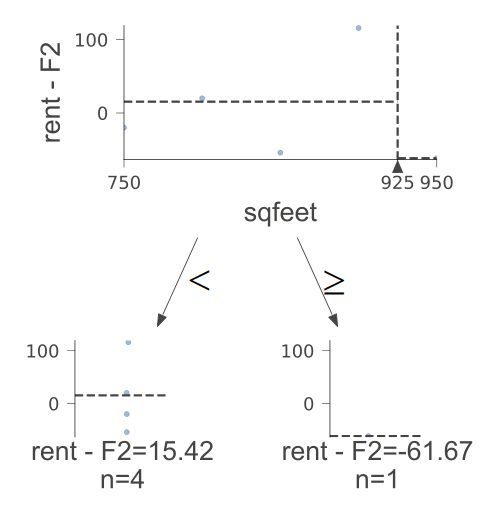

In [102]:
decision_tree_viz_3

In [104]:
print("Samples from node 1")
print(dataset_gbm.iloc[node_samples_3[1]][features + ["rent - F2"]])
print(f"Prediction for node 1 : {dataset_gbm.iloc[node_samples_3[1]]['rent - F2'].mean()}")

Samples from node 1
   sqfeet   rent - F2
0     750  -20.000000
1     800   20.000000
2     850  -54.166667
3     900  115.833333
Prediction for node 1 : 15.416666666666629


In [105]:
print("Samples from node 2")
print(dataset_gbm.iloc[node_samples_3[2]][features + ["rent - F2"]])
print(f"Prediction for node 1 : {dataset_gbm.iloc[node_samples_3[2]]['rent - F2'].mean()}")

Samples from node 2
   sqfeet  rent - F2
4     950 -61.666667
Prediction for node 1 : -61.666666666666515


### Check real rent_gbm predictions with out pre-build composite model


In [106]:
rent_gbm_predictions = rent_gbm.predict(dataset_gbm[features])
rent_gbm_predictions

array([1195.41666667, 1195.41666667, 1349.58333333, 1349.58333333,
       2000.        ])

In [107]:
np.array(dataset_gbm["F3"])

array([1195.41666667, 1195.41666667, 1349.58333333, 1349.58333333,
       2000.        ])

As we can, we have optained the same results. <span class="mark">This means that our building process for composite model is correct.</span> <br>
Just a clarification, our composite model is based on already trained weak models from rent_gbm model. We just implemented the building process of the composite model. <br>
This means :
- making predictions for each weak model, 
- calculate/update predictions for our in-progress composite model. (ex. F1 + weak_pred_2)
- calculate residual values, used to train the next weak model on. (ex. rent - F1)
